In [1]:
import json
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd

from collections import Counter
from datetime import datetime
from matplotlib.dates import DateFormatter
from matplotlib.ticker import AutoMinorLocator
from notebook_utils import configure_path, setup_matplotlib

In [2]:
setup_matplotlib()
configure_path()

## Submarine Connectivity

Submarine cables enable international connectivity, critical from financial transactions to global communications and international scientific cooperation. Given its importance, we now analyze Venezuela’s efforts to expand its submarine infrastructure.


Utilizing the Telegeography’s Submarine Cable Map (https://www.submarinecablemap.com), we review the expansion of submarine connectivity in Venezuela and other Latin American countries using the cables’ ready-for-service (RFS) dates. Telegeography’s map offers a detailed list of the cables composing the submarine cable network along with their names, locations of landing points and their RFS dates.

In [3]:
rir = pd.read_csv("data/external/rir.csv")

In [4]:
lacnic_countries = [
    cc.split(",")[0] for cc in rir.loc[rir["rir"] == "LACNIC"]["Country"].str.lower()
]

In [5]:
with open("data/external/04-submarine_cable_map.json") as f:
    scns = json.load(f)

In [6]:
# Filter LATAM submarine cables
added = {}
latam_scns = {}

for scn in scns:
    for landing_point in scn["lp"]:
        country = landing_point.split("-")[-1]
        if country in lacnic_countries:
            if country not in latam_scns.keys():
                latam_scns[country] = []
                added[country] = set()

            if scn["name"] not in added[country]:
                added[country].add(scn["name"])
                latam_scns[country].append(scn)

In [7]:
# Count LATAM countries cables ready for service per year and month
latam_scns_cable_rfs = {}

for country in latam_scns.keys():
    tmp = []

    for scn in latam_scns[country]:
        if "rfs" in scn.keys():
            tmp.append(datetime.strptime(f"{scn['rfs']}/1/1", "%Y/%m/%d"))
        else:
            tmp.append(datetime.strptime(f"1970/1/1", "%Y/%m/%d"))

    latam_scns_cable_rfs[country] = pd.DataFrame(
        Counter(tmp).items(), columns=["date", "scn_cnt"]
    )

In [8]:
# Add LACNIC count too
names = set()
tmp = []

for country in latam_scns.keys():

    for scn in latam_scns[country]:
        if scn["name"] not in names:
            names.add(scn["name"])

            if "rfs" in scn.keys():
                tmp.append(datetime.strptime(f"{scn['rfs']}/1/1", "%Y/%m/%d"))
            else:
                tmp.append(datetime.strptime(f"1970/1/1", "%Y/%m/%d"))


latam_scns_cable_rfs["LACNIC"] = pd.DataFrame(
    Counter(tmp).items(), columns=["date", "scn_cnt"]
)

In [9]:
country_styles = {
    "argentina": {"alpha": 0.75, "lw": 2, "color": "C0", "label": "AR"},
    "brazil": {"alpha": 0.75, "lw": 2, "color": "C1", "label": "BR"},
    "chile": {"alpha": 0.75, "lw": 2, "color": "C2", "label": "CL"},
    "mexico": {"alpha": 0.75, "lw": 2, "color": "C3", "label": "MX"},
    "colombia": {"alpha": 0.75, "lw": 2, "color": "C5", "label": "CO"},
    "venezuela": {"alpha": 0.75, "lw": 2, "color": "purple", "label": "VE"},
}

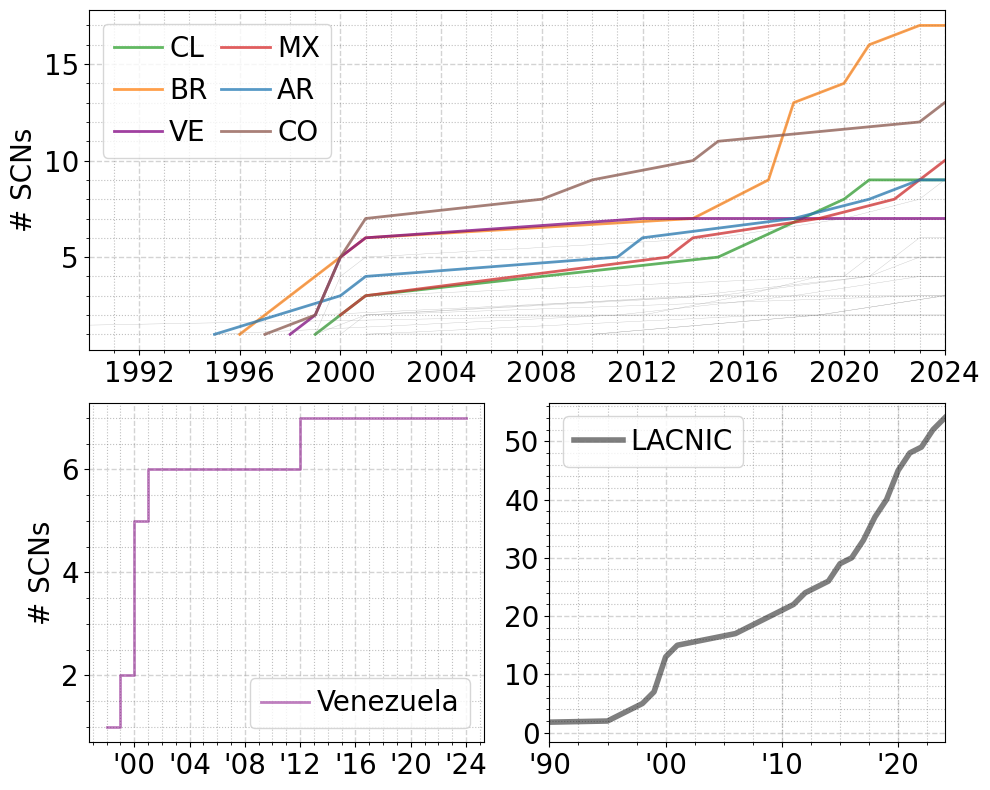

In [10]:
fig = plt.figure(figsize=(10, 8))

gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

i = 0
for country in latam_scns_cable_rfs.keys():
    tmp = latam_scns_cable_rfs[country]
    tmp = tmp.sort_values("date")
    tmp = pd.concat(
        [
            tmp,
            pd.DataFrame(
                [{"date": datetime.strptime(f"2024/1/1", "%Y/%m/%d"), "scn_cnt": 0}]
            ),
        ]
    )

    if country in ["argentina", "brazil", "mexico", "chile", "colombia", "venezuela"]:
        ax1.plot_date(
            tmp["date"],
            tmp["scn_cnt"].cumsum(),
            label=country_styles[country]["label"],
            xdate=True,
            ydate=False,
            tz="UTC",
            alpha=country_styles[country]["alpha"],
            lw=country_styles[country]["lw"],
            fmt="-",
            marker="None",
            color=country_styles[country]["color"],
        )
        i += 1

    if country != "LACNIC":
        ax1.plot_date(
            tmp["date"],
            tmp["scn_cnt"].cumsum(),
            xdate=True,
            ydate=False,
            tz="UTC",
            alpha=0.5,
            lw=0.25,
            fmt="-",
            marker="None",
            color=f"grey",
        )

ax1.set_ylabel("# SCNs", fontsize=20)
ax1.tick_params(labelsize=20)
ax1.legend(
    loc="upper left",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax1.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax1.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax1.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax1.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax1.set_xlim(datetime(1990, 1, 1), datetime(2024, 1, 1))

ax1.yaxis.set_minor_locator(AutoMinorLocator())
ax1.xaxis.set_minor_locator(AutoMinorLocator())

###
country = "venezuela"
tmp = latam_scns_cable_rfs[country]
tmp = tmp.sort_values("date")
tmp = pd.concat(
    [
        tmp,
        pd.DataFrame(
            [{"date": datetime.strptime(f"2024/1/1", "%Y/%m/%d"), "scn_cnt": 0}]
        ),
    ]
)

ax2.plot_date(
    tmp["date"],
    tmp["scn_cnt"].cumsum(),
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.5,
    lw=2,
    fmt="-",
    marker="None",
    color=f"purple",
    label=f"{country.capitalize()}",
    drawstyle="steps-post",
)

ax2.set_ylabel("# SCNs", fontsize=20)
ax2.tick_params(labelsize=20)
ax2.legend(
    loc="lower right",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax2.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax2.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax2.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax2.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax2.yaxis.set_minor_locator(AutoMinorLocator())
ax2.xaxis.set_minor_locator(AutoMinorLocator())

ax2.xaxis.set_major_formatter(DateFormatter("'%y"))
ax2.xaxis.set_major_locator(mdates.YearLocator(4))


###
country = "LACNIC"
tmp = latam_scns_cable_rfs[country]
tmp = tmp.sort_values("date")
tmp = pd.concat(
    [
        tmp,
        pd.DataFrame(
            [{"date": datetime.strptime(f"2024/1/1", "%Y/%m/%d"), "scn_cnt": 0}]
        ),
    ]
)

ax3.plot_date(
    tmp["date"],
    tmp["scn_cnt"].cumsum(),
    xdate=True,
    ydate=False,
    tz="UTC",
    alpha=0.5,
    lw=4,
    fmt="-",
    marker="None",
    color=f"black",
    label=f"{country}",
)

ax3.tick_params(labelsize=20)
ax3.legend(
    loc="upper left",
    ncol=2,
    frameon=True,
    fontsize=20,
    handletextpad=0.25,
    columnspacing=0.5,
    handlelength=1.75,
)

ax3.yaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")
ax3.xaxis.grid(True, linestyle="--", color="darkgrey", lw=1, alpha=0.5, which="major")

ax3.yaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")
ax3.xaxis.grid(True, linestyle=":", color="grey", alpha=0.5, which="minor")

ax3.yaxis.set_minor_locator(AutoMinorLocator())
ax3.xaxis.set_minor_locator(AutoMinorLocator())

ax3.xaxis.set_major_formatter(DateFormatter("'%y"))
ax3.xaxis.set_major_locator(mdates.YearLocator(10))
ax3.set_xlim(datetime(1990, 1, 1), datetime(2024, 1, 1))

fig.subplots_adjust(hspace=0)
fig.tight_layout()
fig.savefig("figures/04-submarine_cable_network_latam.pdf")

The figure presents three panels with the growth of the number of cables connecting countries in the region. The top panel provides a country-level comparison across countries in the LACNIC region, including Venezuela. The lower-left panel focuses specifically on Venezuela, zooming into the evolution of cable deployments within the country, while the lower-right panel shows the total number of cables reaching the shores of any country within the region.

The deployment of submarine cables in Latin America is characterized by two phases: pre and post the dot-com bubble. While the region witnessed considerable growth before 2000, there has been an even more pronounced expansion of cables over the last 15 years. Over these period, Latin America experienced a significant economic bonanza due to the surge in commodity prices, which are the primary exports for all Latin American countries. However, Venezuela did not participate in this second wave of expansion and ranked at the bottom of submarine cable deployment during this timeframe.

In [11]:
# Count submarine cables per country RFS after 2010
l = []

for country in latam_scns_cable_rfs.keys():
    tmp = latam_scns_cable_rfs[country]
    tmp = tmp.sort_values("date")
    c = tmp.loc[tmp["date"] > datetime(2010, 1, 1)]["scn_cnt"].sum()

    l.append((country, c))

scns_since2010 = pd.DataFrame(l, columns=["country", "scn_cnt"])
scns_since2010.sort_values("scn_cnt")

,country,scn_cnt
17,nicaragua,0
7,haiti,0
2,venezuela,1
16,honduras,1
18,aruba,1
14,belize,1
3,guyana,2
4,suriname,2
12,peru,2
11,guatemala,3


In [12]:
# Compare submarine cable count per country RFS each month and year, and their cumulative sum
country = "LACNIC"

for country in ["brazil", "colombia", "chile", "argentina", "LACNIC"]:
    tmp = latam_scns_cable_rfs[country]
    tmp = tmp.sort_values("date")
    tmp = pd.concat(
        [
            tmp,
            pd.DataFrame(
                [{"date": datetime.strptime(f"2024/1/1", "%Y/%m/%d"), "scn_cnt": 0}]
            ),
        ]
    )

    tmp["cumsum"] = tmp["scn_cnt"].cumsum()
    s = tmp.loc[tmp["date"] < datetime(2000, 2, 1)].iloc[-1]
    e = tmp.iloc[-1]

    print(country)
    display(pd.DataFrame([s, e]))

brazil


,date,scn_cnt,cumsum
0,2000-01-01,4,5
0,2024-01-01,0,17


colombia


,date,scn_cnt,cumsum
3,2000-01-01,3,5
0,2024-01-01,0,13


chile


,date,scn_cnt,cumsum
5,2000-01-01,1,2
0,2024-01-01,0,9


argentina


,date,scn_cnt,cumsum
3,2000-01-01,2,3
0,2024-01-01,0,9


LACNIC


,date,scn_cnt,cumsum
5,2000-01-01,6,13
0,2024-01-01,0,54


In [13]:
print(s, e)

date       2000-01-01 00:00:00
scn_cnt                      6
cumsum                      13
Name: 5, dtype: object date       2024-01-01 00:00:00
scn_cnt                      0
cumsum                      54
Name: 0, dtype: object


Between 2000 and 2024, the number of cables in the region underwent a substantial expansion, growing from 13 to 54. Notable examples include Brazil, growing from 5 to 17 cables, Colombia from 5 to 13, and the southernmost countries, with Chile expanding from 2 to 9 cables and Argentina from 3 to 9.

In contrast, during this period, only Nicaragua and Haiti did not expand their cable infrastructure, while Venezuela, along with Honduras, Aruba, and Belize, only added one cable. Venezuela, the wealthiest country in the region in 2001, stands out in the set. The only cable that landed in Venezuela in the past decade is the ALBA cable, connecting Cuba and Venezuela, specifically designed during Hugo Chavez’s presidency to grant Cuba access to the Internet.